In [1]:
########################################################################
#
# Example of the ptychograpic reconstruction for simulated near field data
# (c) ESRF 2017-present
# Authors: Vincent Favre-Nicolin <favre@esrf.fr>
#
########################################################################
%matplotlib notebook
#import os
#os.environ['PYNX_PU'] = 'cuda'
import matplotlib.pyplot as plt

import timeit
import numpy as np
from pynx.ptycho import simulation, shape

from pynx.ptycho import *

In [2]:
##################
detector_distance = 0.05
wavelength = 0.7e-10
pixel_size_detector = 50e-9
# Simulation of the ptychographic data:
n = 256
obj_info = {'type': 'phase_ampl', 'phase_stretch': np.pi / 2, 'alpha_win': .2}

#  Not a very good 'near field' example (usually this is full field) but good enough for demo
probe_info = {'type': 'near_field', 'aperture': (8e-6, 8e-6), 'defocus': 0.01, 'shape': (n, n)}

# 50 scan positions correspond to 4 turns, 78 to 5 turns, 113 to 6 turns
scan_info = {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 80}
data_info = {'num_phot_max': 1e9, 'bg': 0, 'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector, 'noise': 'poisson', 'near_field': True}

# Initialisation of the simulation
s = simulation.Simulation(obj_info=obj_info, probe_info=probe_info, scan_info=scan_info, data_info=data_info)

# Data simulation: probe.show(), obj.show(), scan.show() and s.show_illumination_sum() will visualise the integrated total coverage of the beam
s.make_data()

posx, posy = s.scan.values
ampl = s.amplitude.values  # square root of the measured diffraction pattern intensity

Simulating object: phase_ampl
Simulating probe: near_field
Simulating scan: spiral
Simulating ptychographic data [80 frames].


Parameters of the simulation:
Data info: {'pix_size_direct_nm': 10, 'num_phot_max': 1000000000.0, 'nb_photons_per_frame': 100000000.0, 'bg': 0, 'beam_stop_transparency': 0, 'noise': 'poisson', 'wavelength': 7e-11, 'detector_distance': 0.05, 'detector_pixel_size': 5e-08, 'near_field': True}
Scan info: {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 80, 'integer_values': True}
Object info: {'type': 'Custom', 'phase_stretch': 1.5707963267948966, 'alpha_win': 0.2}
Probe info: {'type': 'near_field', 'shape': (256, 256), 'sigma_pix': (50, 50), 'rotation': 0, 'aperture': (8e-06, 8e-06), 'defocus': 0.01}


In [3]:
##################
# Evaluation:
# Size of the reconstructed object (obj)
nyo, nxo = shape.calc_obj_shape(posx, posy, ampl.shape[1:])

# Initial object
# obj_init_info = {'type':'flat','shape':(nx,ny)}
obj_init_info = {'type': 'random', 'range': (0, 1, 0, 0.5), 'shape': (nyo, nxo)}

# Initial probe
probe_init_info = {'type': 'near_field', 'aperture': (7e-6, 7e-6), 'defocus': 0.015, 'shape': (n, n)}
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)

init.make_obj()
init.make_probe()

data = PtychoData(iobs=ampl ** 2, positions=(posx * pixel_size_detector, posy * pixel_size_detector),
                  detector_distance=detector_distance, mask=None,
                  pixel_size_detector=pixel_size_detector, wavelength=wavelength, near_field=True)

p = Ptycho(probe=init.probe.values, obj=init.obj.values, data=data, background=None)

# Initial scaling is important to avoid overflows during ML
p = ScaleObjProbe(verbose=True) * p

Simulating object: random
Simulating probe: near_field
ScaleObjProbe: 23846.982 110478.92 33941.18501024905 396.5395306195893 85.59344314937384


<IPython.core.display.Javascript object>


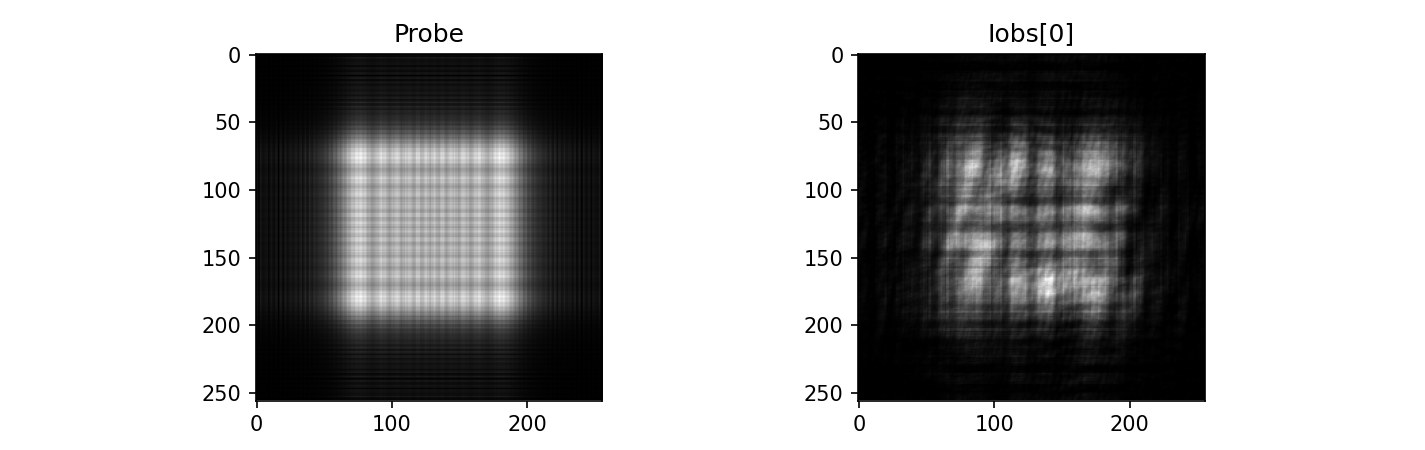

Text(0.5, 1.0, 'Iobs[0]')

In [4]:
plt.figure(figsize=(9.5,3))

plt.subplot(121)
plt.imshow(abs(p.get_probe()[0]), cmap='gray')
plt.title("Probe")

plt.subplot(122)
plt.imshow(fftshift(p.data.iobs[0]), cmap='gray')
plt.title("Iobs[0]")


<IPython.core.display.Javascript object>


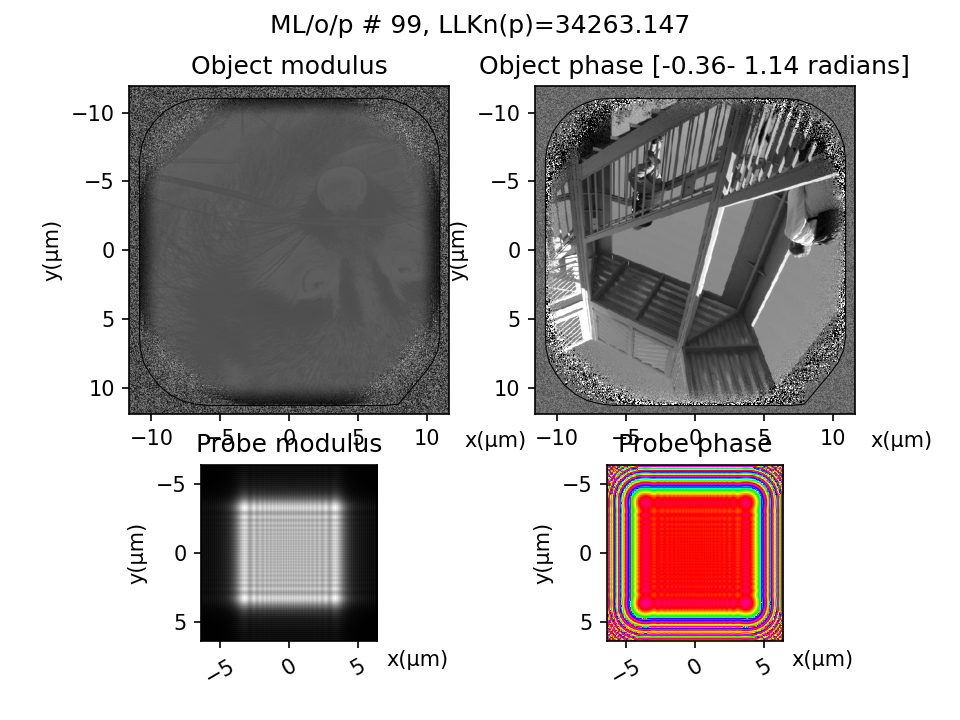

DM/o/p     #  0 LLK= 17641838.40(p) 674249624780.80(g) 29710643.20(e), nb photons=5.364388e+14, dt/cycle=0.712s
DM/o/p     # 20 LLK= 182929.30(p) 101786988.80(g) 361849.28(e), nb photons=5.927693e+14, dt/cycle=0.023s
DM/o/p     # 40 LLK= 97000.99(p) 44318713.60(g) 190780.11(e), nb photons=5.914799e+14, dt/cycle=0.023s
DM/o/p     # 60 LLK= 98474.85(p) 36312300.80(g) 191900.58(e), nb photons=5.893837e+14, dt/cycle=0.021s
DM/o/p     # 80 LLK= 126030.15(p) 45673728.00(g) 242921.25(e), nb photons=5.874350e+14, dt/cycle=0.021s
DM/o/p     # 99 LLK= 225006.25(p) 114411404.80(g) 426950.30(e), nb photons=5.848794e+14, dt/cycle=0.021s
AP/o/p     #100 LLK= 225006.40(p) 114411392.00(g) 426950.60(e), nb photons=5.848793e+14, dt/cycle=0.271s
AP/o/p     #120 LLK= 46172.03(p) 35012016.00(g) 92567.11(e), nb photons=5.900937e+14, dt/cycle=0.018s
AP/o/p     #139 LLK= 38341.74(p) 33731539.20(g) 77431.83(e), nb photons=5.975478e+14, dt/cycle=0.019s
ML/o/p     #141 LLK= 37985.78(p) 33620499.20(g) 76709.22(e)

In [5]:
plt.figure()  # new figure
p = DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20) ** 100 * p
p = AP(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20) ** 40 * p
p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20) ** 100 * p